In [1]:
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize']= (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 2)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [4]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

# https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [5]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels = 3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    
    new_shape = tf.cast(shape* scale, tf.int32)
    
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [6]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
        
    plt.imshow(image)
    if title:
        plt.title(title)

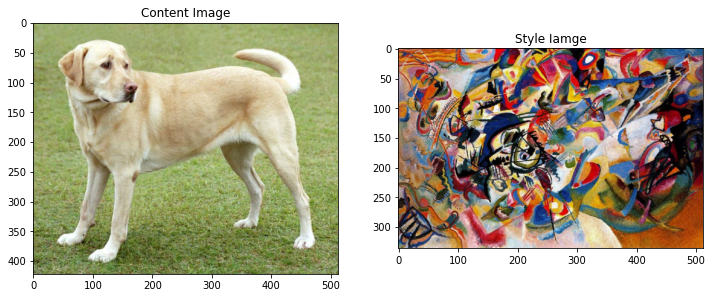

In [7]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1,2,1)
imshow(content_image, 'Content Image')

plt.subplot(1,2,2)
imshow(style_image, 'Style Iamge')

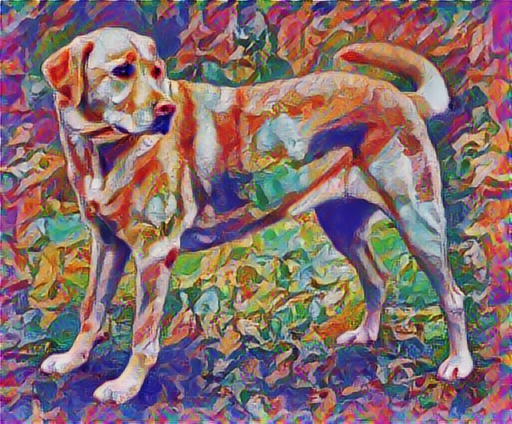

In [8]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [9]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574717952/574710816 [==============================] - 50s 0us/step


TensorShape([1, 1000])

In [16]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('Labrador_retriever', 0.4931709),
 ('golden_retriever', 0.23665306),
 ('kuvasz', 0.036357537),
 ('Chesapeake_Bay_retriever', 0.024182757),
 ('Greater_Swiss_Mountain_dog', 0.018646078)]

In [18]:
vgg = tf.keras.applications.VGG19(include_top = False, weights = 'imagenet')

print()
for layer in vgg.layers:
    print(layer.name)

80142336/80134624 [==============================] - 7s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [19]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [22]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable=False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]
    
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [23]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image * 255)

for name, output in zip(style_layers, style_outputs):
    print(name)
    print('  shape: ', output.numpy().shape)
    print('  min: ', output.numpy().min())
    print('  max: ', output.numpy().max())
    print('  mean: ', output.numpy().mean())
    print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5256
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8857
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.239
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.137
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2537
  mean:  59.179478



In [24]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [26]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        
    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])
        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]
        
        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}
        
        style_dict = {style_name: value
                     for style_name, value
                     in zip(self.style_layers, style_outputs)}
        return {'content': content_dict, 'style':style_dict}

In [27]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Style:')
for name, output in sorted(results['style'].items()):
    print('  ', name)
    print('    shape: ', output.numpy().shape)
    print('    min: ', output.numpy().min())
    print('    max: ', output.numpy().max())
    print('    average: ', output.numpy().mean())
    print()
    
print('Contents')
for name, output in sorted(results['content'].items()):
    print('  ', name)
    print('    shape: ', output.numpy().shape)
    print('    min: ', output.numpy().min())
    print('    max: ', output.numpy().max())
    print('    average: ', output.numpy().mean())

Style:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0055228453
    max:  28014.555
    average:  263.79025

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.484
    average:  9100.949

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.44
    average:  7660.9766

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320502.0
    average:  134288.84

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.39
    average:  1487.0381

Contents
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.8792
    average:  13.764149


In [28]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [29]:
image = tf.Variable(content_image)

In [30]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min = 0.0, clip_value_max = 1.0)

In [31]:
opt = tf.optimizers.Adam(learning_rate = 0.02, beta_1 = 0.09, epsilon = 1e-1)

In [32]:
style_weight = 1e-2
content_weight = 1e4

In [36]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers
    
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [37]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

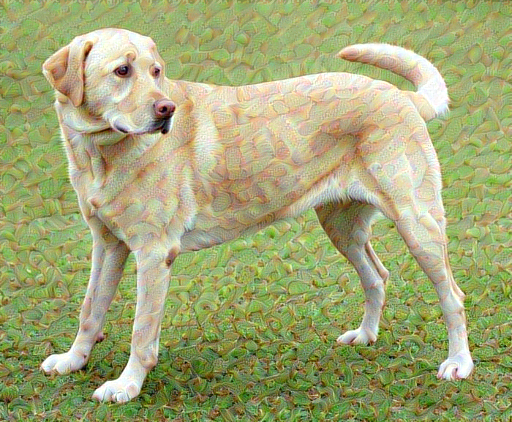

In [38]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

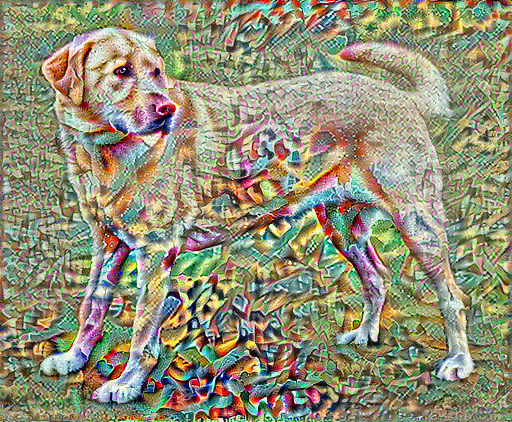

train step: 1000
time: 149.2


In [39]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print('train step: {}'.format(step))
    
end = time.time()
print('time: {:.1f}'.format(end-start))

In [40]:
def high_pass_x_y(image):
    x_var = image[:,:,1:,:] - image[:,:,:-1,:]
    y_var = image[:,1:,:,:] - image[:,:-1,:,:]
    return x_var, y_var

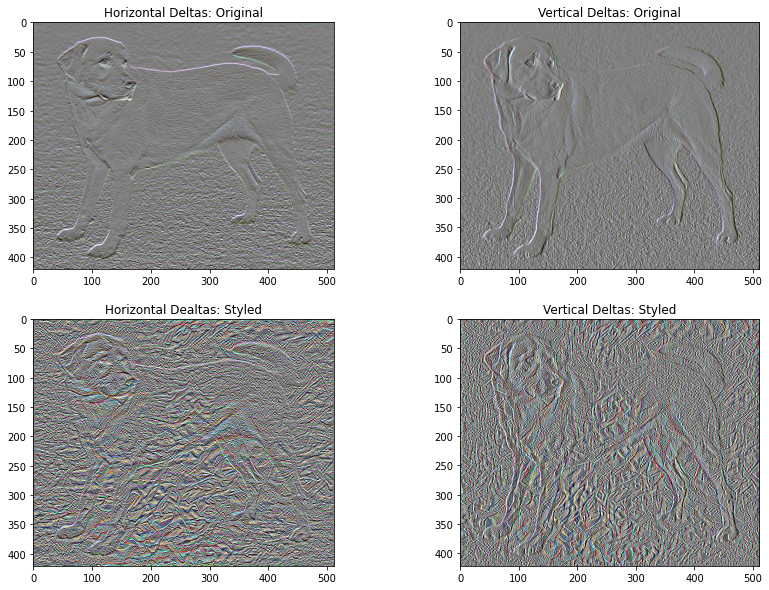

In [41]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), 'Horizontal Deltas: Original')

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), 'Vertical Deltas: Original')

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), 'Horizontal Dealtas: Styled')

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), 'Vertical Deltas: Styled')

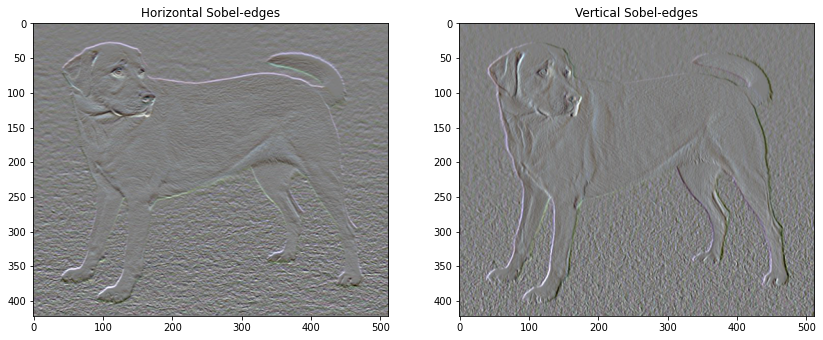

In [42]:
plt.figure(figsize=(14,10))
sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), 'Horizontal Sobel-edges')
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), 'Vertical Sobel-edges')

In [43]:
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [44]:
total_variation_loss(image).numpy()

164895.27

In [45]:
tf.image.total_variation(image).numpy()

array([164895.27], dtype=float32)

In [46]:
total_variation_weight=30

In [47]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight * tf.image.total_variation(image)
        
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [48]:
image = tf.Variable(content_image)

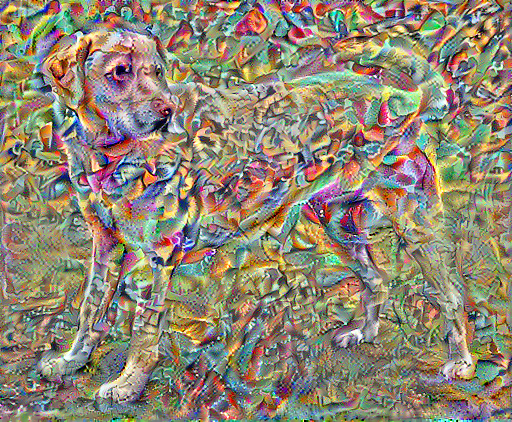

train step: 1000
time: 147.0


In [51]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print('.', end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print('train step: {}'.format(step))

end = time.time()
print('time: {:.1f}'.format(end-start))